# Investigation

This will be my attempt at creating something similar to the original notebook.
A few things to think about:

- After doing the initial recreation, let's look at the Kaggle tutorials and add in other data points
  - Close - n datapoints? So we're not just using the very latest close price
  - High/Low/Open - see if these are useful
  - Tick volume - see if this is useful
- As well as looking at root mean squared error, lets look at statistics
  - When model predict a move of more than 1, 2, 3 ATR in next 10, 15 candles, how often does this actually happen?
    - When it's correct, how often is there a move in the opposite direction first that was not seen by model
  - When it predicts a positive or negative move, how often is it actually correct?
    - Look at this over different candle counts. ie. Candle 1, 10, 15
- Rather than predict the price, try predict the change?
  - The price may hit values never encountered in training which may make it harder to predict

Hopefully, we will find models that are better than the original but there's not going to be a model we can use for native price forcasting. But perhaps we can use it to inform other prediction algorithms. ie. If we have an algorithm that identifies support and resistance areas, and the model is good a predicting the direction of the movement then it can be used to inform on where to place a trade even if it can't predict the price.

### Note

In this repo I am using a custom module `malfoy.metatrader` that I built on top of the `MetaTrader5` package. This interfaces directly with MetaTrader to pull up-to-date data. I hope to eventually make this open-source but for now it's a private module. I have also saved the data used in `./data/new` so it can be reused.

In [72]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib widget

In [73]:
# Functions

def CreateScaler(data: pd.Series) -> MinMaxScaler:
  data = np.array(data).reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data)

  return scaler

def GetScaledData(data: pd.Series, scaler: MinMaxScaler) -> pd.Series:
  data = np.array(data).reshape(-1, 1)
  return scaler.transform(data)

def GetTimeStepDataFrame(data: pd.DataFrame, timeSteps: int, trainingColumns: list, predictionColumn: str) -> pd.DataFrame:
  
  timeStepData = pd.DataFrame(index=data.index)

  for column in trainingColumns:
    for i in range(1, timeSteps + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].shift(i)

  timeStepData[predictionColumn] = data[predictionColumn]
  
  timeStepData = timeStepData.dropna()

  return timeStepData

def GetTimeStepDict(data: pd.DataFrame, timeSteps: int, trainingColumns: list) -> dict:
  
  timeStepData = {}

  for column in trainingColumns:
    for i in range(1, timeSteps + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].iloc[timeSteps - i]

  return timeStepData

## Variables

These core variables are used throughout the scripts. The instrument and granularity variables can be used to change the target of predictions. These correspond to the data found in `./data/new/`

*Prediction Variables*:
- instrument - the instrument being predicted
- granularity - the timeframe being predicted on (One minute, one hour, one day, etc)
- predictionTimeSteps - the number of previous time steps to use in making the prediction for the current candle
- predictionColumn - the column from the dataframe we are trying to predict

In [74]:
# Set script variables
seedValue = 72
trainingSizePercent = 0.7
inputDataFolder = "./input/new"

# Change these for prediction changes
instrument = "BTCUSD"
granularity = "D1"
predictionTimeSteps = 15
predictionColumn = "midCloseDelta"

In [75]:
# Import data

rawDataFilePath = "{0}/{1}_{2}.csv".format(inputDataFolder, instrument, granularity)
rawData = pd.read_csv(rawDataFilePath)

rawData

,Unnamed: 0,instrument,granularity,time,stringTime,volume,bidOpen,bidHigh,bidLow,bidClose,midOpen,midHigh,midLow,midClose,askOpen,askHigh,askLow,askClose
0,0,BTCUSD,H1,2021-09-21 21:00:00,2021-09-21T21:00:00,4718,41667.50,42790.5,41604.50,42182.50,41667.50,42790.5,41604.50,42182.50,41667.50,42790.5,41604.50,42182.50
1,1,BTCUSD,H1,2021-09-21 22:00:00,2021-09-21T22:00:00,3598,42182.50,42449.5,41652.50,41977.50,42182.50,42449.5,41652.50,41977.50,42182.50,42449.5,41652.50,41977.50
2,2,BTCUSD,H1,2021-09-21 23:00:00,2021-09-21T23:00:00,6578,41980.00,42298.5,40577.50,40961.50,41980.00,42298.5,40577.50,40961.50,41980.00,42298.5,40577.50,40961.50
3,3,BTCUSD,H1,2021-09-22 00:00:00,2021-09-22T00:00:00,5583,40923.50,41996.5,39543.50,41363.50,40923.50,41996.5,39543.50,41363.50,40923.50,41996.5,39543.50,41363.50
4,4,BTCUSD,H1,2021-09-22 01:00:00,2021-09-22T01:00:00,7025,41363.50,41632.5,40440.50,40492.00,41363.50,41632.5,40440.50,40492.00,41363.50,41632.5,40440.50,40492.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,BTCUSD,H1,2022-04-20 08:00:00,2022-04-20T08:00:00,7463,41343.50,41455.0,41293.50,41440.00,41343.50,41455.0,41293.50,41440.00,41343.50,41455.0,41293.50,41440.00
4996,4996,BTCUSD,H1,2022-04-20 09:00:00,2022-04-20T09:00:00,8067,41441.50,41470.5,41377.77,41470.50,41441.50,41470.5,41377.77,41470.50,41441.50,41470.5,41377.77,41470.50
4997,4997,BTCUSD,H1,2022-04-20 10:00:00,2022-04-20T10:00:00,9544,41476.00,41629.5,41277.50,41338.49,41476.00,41629.5,41277.50,41338.49,41476.00,41629.5,41277.50,41338.49
4998,4998,BTCUSD,H1,2022-04-20 11:00:00,2022-04-20T11:00:00,7959,41339.57,41520.0,41298.50,41476.50,41339.57,41520.0,41298.50,41476.50,41339.57,41520.0,41298.50,41476.50


In [76]:
# Pre-process data

ppData = rawData.copy()

# New columns
ppData["askCloseDelta"] = ppData["askClose"] - ppData["askClose"].shift(1)
ppData["midCloseDelta"] = ppData["midClose"] - ppData["midClose"].shift(1)
ppData["bidCloseDelta"] = ppData["bidClose"] - ppData["bidClose"].shift(1)

# Split data in to test and train
trainingEntryCount = math.floor(len(ppData) * trainingSizePercent)
trainingData = ppData.iloc[0:trainingEntryCount, :]
testData = ppData.iloc[trainingEntryCount:len(ppData), :]

# Scale required columns
scaledColumns = ["bidOpen", "bidHigh", "bidLow", "midOpen", "midHigh", "midLow", "askOpen", "askHigh", "askLow", "volume", "bidClose", "midClose", "askClose", "midCloseDelta"]

scalerDict = {}

for column in scaledColumns:
  scalerDict[column] = CreateScaler(trainingData[column])
  
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
  testData[column] = GetScaledData(testData[column], scalerDict[column])

# Add previous time steps as data available for making prediction
trainingColumns = ["midClose", "midCloseDelta"]

trainingTimeStepData = GetTimeStepDataFrame(trainingData, timeSteps=predictionTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_trainingData = trainingTimeStepData.drop(columns=predictionColumn)
Y_trainingData = trainingTimeStepData[predictionColumn]

testTimeStepData = GetTimeStepDataFrame(testData, timeSteps=predictionTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_testData = testTimeStepData.drop(columns=predictionColumn)
Y_testData = testTimeStepData[predictionColumn]

print("X_trainingData shape:", X_trainingData.shape)
print("Y_trainingData shape:", Y_trainingData.shape)
print("X_testData shape:", X_testData.shape)
print("Y_testData shape:", Y_testData.shape)

X_trainingData.to_csv("./train.csv")
trainingData.to_csv("./train_raw.csv")
X_testData.to_csv("./test.csv")
testData.to_csv("./test_raw.csv")

C:\Users\sambe\AppData\Local\Temp\ipykernel_14820\1167521989.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_14820\1167521989.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData[column] = GetScaledData(testData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_14820\1167521989.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

X_trainingData shape: (3484, 30)
Y_trainingData shape: (3484,)
X_testData shape: (1485, 30)
Y_testData shape: (1485,)


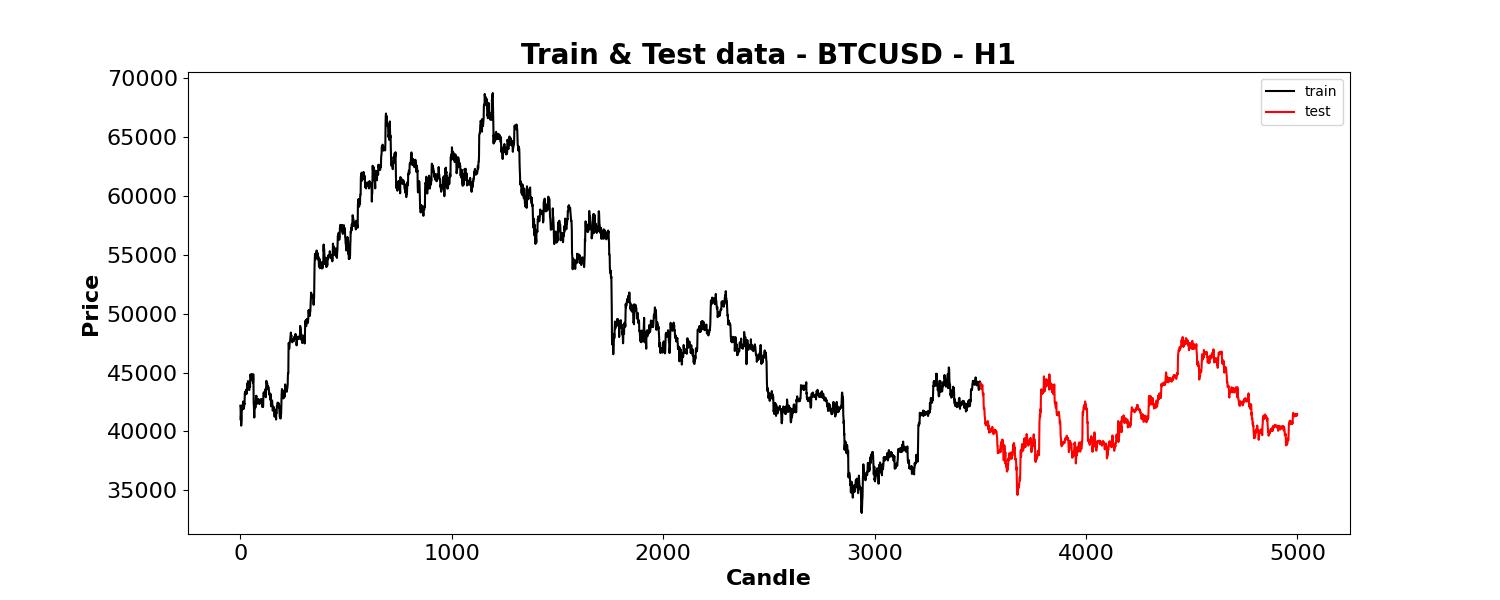

In [77]:
# Plot test and train data

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')

# Formatting
ax.set_title('Train & Test data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [78]:
# Train model

model = XGBRegressor(n_estimators=10000, seed=seedValue)
model.fit(X_trainingData, Y_trainingData, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=72,
             reg_alpha=0, reg_lambda=1, ...)

In [79]:
# Model testing and evaluation

predictions = model.predict(X_testData)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_testData, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(Y_testData, predictions))))

Mean Absolute Error - MAE : 0.04286904103324271
Root Mean squared Error - RMSE : 0.060998396024877756


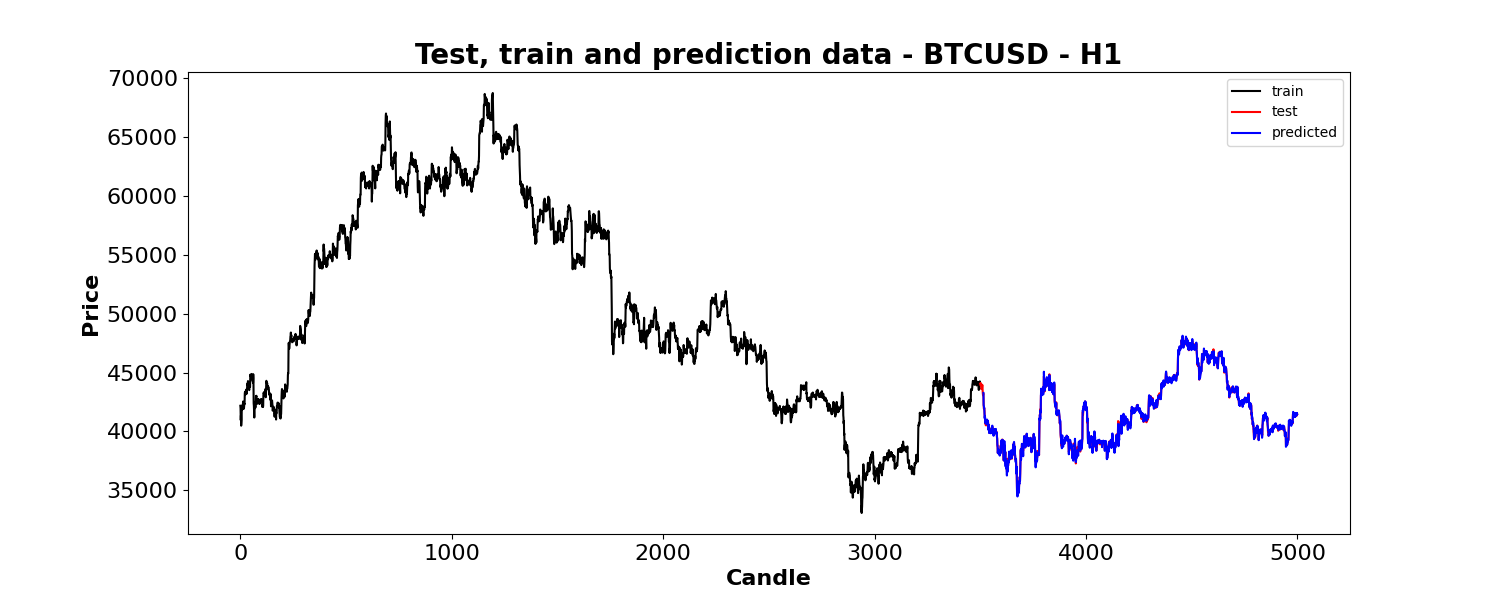

In [80]:
# Plot the predicted vs actual
plotTestData = X_testData.copy()

plotTestData["midClose"] = testData["midClose"]
plotTestData["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotTestData["midClose"]).reshape(-1, 1))
plotTestData["PredictedValue"] = scalerDict[predictionColumn].inverse_transform(np.array(predictions).reshape(-1, 1))
plotTestData["PredictedValue"] = plotTestData["PredictedValue"] + plotTestData["midClose"]

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')
sns.lineplot(x = plotTestData.index, y = plotTestData['PredictedValue'], color = 'blue')

# Formatting
ax.set_title('Test, train and prediction data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test', "predicted"))


## Future prediction

This next part is an attempt to use previous predictions to then predict the next step. This will obviously not be as accurate as predicting one step ahead for two reasons:
- The further in the future you are trying to predict, the higher the uncertainty.
- We will be using previous predictions as inputs to the next prediction. This will add error and more uncertainty.]

## Findings

Using this current method for future trends seems highly error-prone. Assuming there is nothing wrong in the code below (I've double checked but there still could be), creating predictions of the previous predictions just introduces too much error. One time step seems to be within a reasonable error range but after that it declines rapidly.

I'm going to create another notebook that predicts the xth step in the future. ie. instead of predicting the next candle close, predict the 5th candle close. It will be interesting to see the accuracy of this.

In [81]:
futureTestData = testData.copy().head(200)

stepsToPredict = 200

# Sets the index value for the next dataframe entry
nextIndexValue = futureTestData.index.values[-1] + 1

for i in range(stepsToPredict):
  previousClose = scalerDict["midClose"].inverse_transform(np.array(futureTestData["midClose"].values[-1]).reshape(-1, 1))[0][0]

  # Get values needed to predict next step
  nextTimeStep = GetTimeStepDict(futureTestData.tail(predictionTimeSteps), timeSteps=predictionTimeSteps, trainingColumns=trainingColumns)
  
  # Predict next step
  prediction = model.predict(pd.DataFrame(nextTimeStep, index=[nextIndexValue]))[0]
  
  # Store predictions in dataframe
  nextTimeStep[predictionColumn] = prediction
  predictionUnscaled = scalerDict[predictionColumn].inverse_transform(np.array(prediction).reshape(-1, 1))
  
  predictedClose = previousClose + predictionUnscaled
  nextTimeStep["midClose"] = scalerDict["midClose"].transform(predictedClose)[0][0]
  futureTestData = pd.concat([futureTestData, pd.DataFrame(nextTimeStep, index=[nextIndexValue])])

  print("Previous close:", previousClose)
  print("Predicted move:", predictionUnscaled[0][0])
  print("Predicted close:", predictedClose[0][0])

  nextIndexValue = nextIndexValue + 1

Previous close: 38740.16
Predicted move: 30.549788
Predicted close: 38770.71
Previous close: 38770.71019619942
Predicted move: -18.368134
Predicted close: 38752.344
Previous close: 38752.34214993477
Predicted move: -12.888726
Predicted close: 38739.453
Previous close: 38739.453111925126
Predicted move: -299.93994
Predicted close: 38439.51
Previous close: 38439.5124229908
Predicted move: 169.72058
Predicted close: 38609.23
Previous close: 38609.230114793776
Predicted move: 53.79068
Predicted close: 38663.02
Previous close: 38663.018612566
Predicted move: -37.597042
Predicted close: 38625.42
Previous close: 38625.42098736763
Predicted move: -27.123465
Predicted close: 38598.297
Previous close: 38598.297562303545
Predicted move: -64.70194
Predicted close: 38533.594
Previous close: 38533.59348805428
Predicted move: -0.21195579
Predicted close: 38533.383
Previous close: 38533.38128788948
Predicted move: -67.051346
Predicted close: 38466.332
Previous close: 38466.33027981759
Predicted move: 

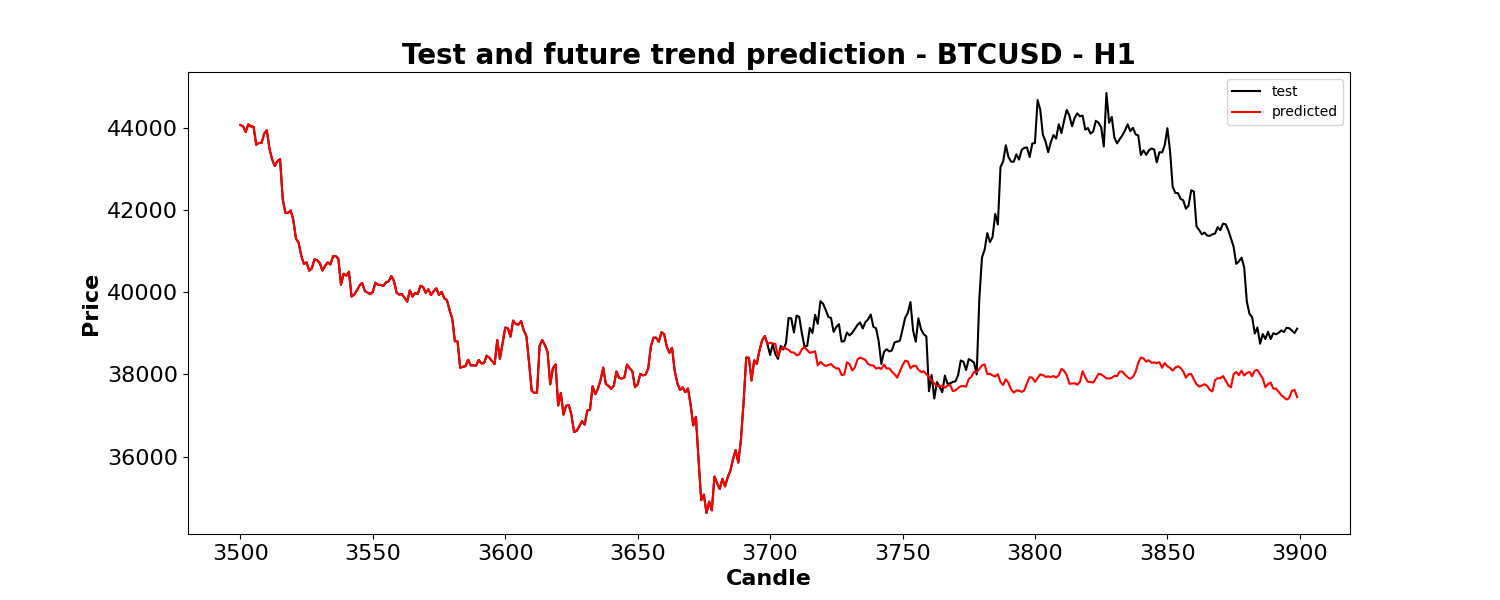

In [82]:
# Plot predicted steps
plotFutureData = futureTestData.copy()

plotTestSubset = testData.loc[plotFutureData.index.values]

plotFutureData["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotFutureData["midClose"]).reshape(-1, 1))
plotTestSubset["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotTestSubset["midClose"]).reshape(-1, 1))

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = plotTestSubset.index.values, y = plotTestSubset['midClose'], color = 'black')
sns.lineplot(x = plotFutureData.index.values, y = plotFutureData['midClose'], color = 'red')

# Formatting
ax.set_title('Test and future trend prediction - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('test', "predicted"))